In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ER 131] Homework 9: Classification with Decision Trees
----

This homework will build on the methods introduced in Lab 9 that predict qualitative variables. In addition to logistic regression and KNN, decision trees are a powerful prediction method and are relatively easy to interpret. A decision tree can explain exactly why a specific prediction was made. As we'll see in this HW, using a single decision tree to make a prediction often isn't the best performing method. However, ensemble methods such as random forests and bagging use multiple trees to reach a "consensus" decision and typically perform better than single decision trees. In this homework, we'll start by building a single decision tree and then see how ensemble methods perform by comparison.

Trees are, overall, a relatively accessible method for predictive modeling since they are used for both regression and classification and can take in both continuous and categorical data. Decision trees are covered in sections 8.1-8.3 of ISLP.

In this homework, we'll implement various ensemble methods using scikit-learn. 

It'll be a comprehensive survey of trees and the multitude of algorithms that arise from one tree!

By this end of this homework, you should be able to:
* Run a random forest and bagging model in scikit-learn
* Use training, testing, and validation datasets appropriately
* Explain the outputs of a model (performance, precision, recall, importance plots)


### Table of Contents

0. [Project](#project)<br>
1. [The data](#data) <br>
1. [Implementing decision trees with scikit-learn](#sk) <br>
1. [Ensemble methods](#ensemble) <br>

**Dependencies:**

In [2]:
# Load dependencies
import urllib
import os.path
from shutil import copyfile

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

## Section 0: Project (5 pts) <a name='project'></a>

***For parts 0.1 -0.3, your group may develop a common response.***

**Question 0.1** A step that can help in defining a project is writing down your response (dependent) and your feature/predictor (independent) variables. 

1. At this point, what do you think your response variable will be (i.e. what your model is trying to predict)?  
2. Based on this variable are you going to be doing regression or classification?
2. Does your response variable already exist in a dataset in the form that you need it?  
3. How many observations do you expect to have in your sample?  

If you're choosing between a few options at this point, you can discuss more than one potential response variable.

*YOUR ANSWER HERE*

**Question 0.2** Questions to answer:  
1. What are the features that you might include in your model? 
2. Are there any features that you want to include, but you haven't figured out where to get or how to calculate the data? 
3. Where will the data for the features come from when the model is used for prediction? In other words, in this project, you will use observed $X$ and $y$ data to train, test, and cross-validate a model of the form $\hat {y_i} = \hat {f}(X_i)$. Ideally, you would then be able to use your model to predict $y$ in settings (e.g., locations, times) for which you *don't* have access to observations of the response variable. Are feature (i.e., $X$) data available for the settings in which you would want to predict $y$? 

*YOUR ANSWER HERE*

**Question 0.3** Based on your answer to the questions above, think about what constitutes an "ideal" observation of your data. Try to write out your data in the form

$$y_i = f(x_{1i}, x_{2i},...) + \epsilon_i$$

where $y_i$ is your response variable and $x_{1i}, x_{2i},...$ are your features. 

Specific questions to answer:

1. What is $y_i$, and what are its units? 
2. What are $x_{1i}, x_{2i},...$? 
3. What does $i$ index in your training data?  A point in time, a location in space? (Be as specific as you can!)
4. What work do you need to do to make $i$ index the same thing for your response varaible and your features?  As an example of the kind of "work" you'd need to do, it's often necessary to do some kind of aggregation (possibly using the `.resample` method in pandas), such as collapsing observations in time or space.  

As an example, if we were to answer the questions above for the Novotny et al. paper, we would get:<br>
1. $y$ is atmospheric $NO_2$ measurements in $\mu$g/m$^3$<br>
2. $x_1$ is % impervious surface<br>
$x_2$ is % tree canopy<br>
$x_3$ is population<br>
$x_4$ is major road length in km<br>
$x_5$ is minor road length in km<br>
$x_6$ is total road length in km<br>
$x_7$ is elevation in meteres<br>
$x_8$ is distance to coast in km<br>
$x_9$ is ground-based OMI $NO_2$ measurement in $\mu$g/m$^3$,<br>
and 
3. In the training data, $i$ indexes locations of the ground-based measurements.
4. Many of the features need to be aggregated into buffers around the ground-based measurements.  

*YOUR ANSWER HERE*

**Question 0.4** Describe what you did to assist your group this week. Also describe your understanding of what each of your teammates did this week. Please make sure to discuss with them if you are at all unsure of what your teammates did. It's ok if some people do more than others from one week to the next, but you should make sure that everyone's pulling weight over the semester.

*YOUR ANSWER HERE*

---
## Section 1: The data <a name='data'></a>

In this homework, we will return to the [California Communities Environmental Health Screening Tool (CalEnviroScreen)](https://oehha.ca.gov/calenviroscreen), which uses demographic and environmental information to identify communities that are susceptible to various types of pollution. The variables in this dataset contribute to the CES score, which reflects a community's environmental conditions and its vulnerability to environmental pollutants.

Your HW09 folder contains an Excel file downloaded from [here](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40).

Documentation on Pandas' Excel methods can be found [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html). 

**Question 1.1 (1pt):** Load the "DRAFTCES4.0_results" sheet from the Excel file to a Pandas dataframe and assign it to the variable `df`. If you're not sure how to do this, refer back to Lab 2.

In [ ]:
# YOUR CODE HERE
filename = 'CalEnviroScreen_4.0Excel_ADA_D1_2021.xlsx'
xl = pd.ExcelFile(...)
print(xl.sheet_names) # display a list of the sheets in the spreadsheet

df = xl.parse(xl.sheet_names[0]) # display the first sheet as Pandas dataframe
df.head()

In [4]:
# Solution
filename = 'CalEnviroScreen_4.0Excel_ADA_D1_2021.xlsx'
xl = pd.ExcelFile(filename)
print(xl.sheet_names) # display a list of the sheets in the spreadsheet

df = xl.parse(xl.sheet_names[0]) # display the first sheet as Pandas dataframe
df.head()

['DRAFTCES4.0_results', 'Demographic profile', 'Data Dictionary']


,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Lead,Lead Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,2760,Fresno,93706,Fresno,-119.781696,36.709695,94.608491,100.000000,95-100% (highest scores),0.060151,83.671437,13.906348,97.710019,1.122712,98.718108,721.183172,75.501808,92.126975,98.073291,1.435276,45.379656,48953.200520,99.838026,1037.095744,60.3750,89.85,98.905509,54.25,91.524629,2.650,92.222734,0,0.000000,6.0,79.630621,79.091178,9.734997,99.925327,129.54,97.220837,7.80,95.624840,21.47,92.248255,45.1,92.867982,18.0,83.108379,76.6,98.429648,16.2,97.151695,30.7,90.614723,93.732898,9.718389,99.873897
1,6077000700,4177,San Joaquin,95206,Stockton,-121.287873,37.943173,90.831885,99.987390,95-100% (highest scores),0.044902,41.244555,11.884085,72.594897,0.538105,91.151213,388.765624,33.038275,85.184288,93.527264,71.024146,75.035817,5574.027466,92.661351,856.395935,48.2875,72.30,98.358263,95.00,96.591087,1.050,82.466636,14,93.398637,8.6,87.794433,76.202343,9.379423,99.763535,105.88,94.217348,6.88,88.722094,20.26,88.123131,48.9,95.422357,31.9,96.338367,70.6,96.432161,18.5,98.453409,35.2,95.610928,93.402818,9.684166,99.836066
2,6077000100,4055,San Joaquin,95202,Stockton,-121.285363,37.953996,85.750324,99.974779,95-100% (highest scores),0.044739,40.398258,11.875729,72.196640,0.519797,90.628500,388.765624,33.038275,77.832693,87.281199,18.101677,64.828080,3060.288513,81.497633,287.455949,7.6125,57.35,97.026633,81.80,95.746677,1.050,82.466636,14,93.398637,8.5,87.607066,70.206467,8.641416,98.767890,238.03,99.962612,9.72,99.358481,20.57,89.132602,45.7,93.373799,22.1,88.774556,81.8,99.497487,17.9,98.169867,36.4,96.508981,95.708085,9.923180,99.974779
3,6071001600,5527,San Bernardino,91761,Ontario,-117.618013,34.057780,83.556404,99.962169,95-100% (highest scores),0.063273,93.739888,13.785161,97.398880,0.418891,86.011201,839.235788,91.073432,92.361235,98.224405,0.414407,34.204871,13944.633460,98.828806,842.733027,47.2750,56.00,96.862459,36.50,84.863174,2.825,92.867004,4,44.591141,10.0,91.033191,81.244172,10.000000,100.000000,60.88,70.102193,5.62,67.372338,18.57,82.901296,52.2,96.813354,34.1,97.113457,67.1,94.824121,6.7,57.198093,32.1,92.651151,80.589322,8.355640,93.064313
4,6037204920,2639,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.895832,99.949559,95-100% (highest scores),0.046588,49.023024,12.251640,89.209708,0.780833,96.552582,766.840041,83.979554,93.247909,98.715527,0.000000,0.000000,7537.026855,95.352604,2522.622269,92.8375,48.40,96.041591,20.70,70.164191,12.125,99.102623,7,68.845826,4.0,69.325482,77.371189,9.523291,99.863099,76.10,82.764207,7.11,90.890429,20.87,90.154536,50.8,96.155792,21.8,88.440465,64.9,93.505025,5.6,43.807192,25.0,77.953453,83.954388,8.704536,95.775536


----
**Question 1.2 (2pts)** In **your own words**, describe what the `Pollution_Burden_Pctl` category represents using the links above. What is the real-world meaning of a high score? What about a low score?

**ANSWER:** *YOUR ANSWER HERE*

*Solution reference (need to paraphrase for full credit)*

*From CalEnviroScreen: "Pollution Burden scores for each census tract are derived from the average percentiles of the seven Exposures indicators (ozone and PM2.5 concentrations, diesel PM emissions, drinking water contaminants, children’s lead risk from housing, pesticide use, toxic releases from facilities, and traffic density) and the five Environmental Effects indicators (cleanup sites, impaired water bodies, groundwater threats, hazardous waste facilities and generators, and solid waste sites and facilities). Indicators from the Environmental Effects component were given half the weight of the indicators from the Exposures component. The calculated average pollution burden score (average of the indicators) was divided by 10 and rounded to one decimal place for a Pollution Burden score ranging from 0.1 – 10. "*

A high score corresponds to a community facing severe pollution exposure; a low score corresponds to a community with limited pollution exposure. 

### Motivation for what you're about to do.  
In its recent [Draft Scoping Plan](https://ww2.arb.ca.gov/sites/default/files/2022-05/2022-draft-sp.pdf), California's Air Resources Board wrote that they endeavor to "chart the path to a future where race is no longer a predictor of disproportionate burdens from harmful air pollution and climate impacts."

Now, the CES data doesn't have specific information on race.  But it does have data on socioeconomic indicators like education, income, and housing.  These are known to correlate with the racial composition of communities.  

**Let's build a model that uses recent socioeconomic data to classify communities into those with high environmental exposure and those with low exposure.**

The key to what we're doing to do is that we *won't* use any environmental variables as features to predict pollution exposure.  Instead we'll just use socioeconomic indicators like education, income, language use, disease and housing. 

### Let's build the first model. 

For our first model, we'll use the features to predict whether a census tract is in a high pollution burden percentile or a low percentile.  For the sake of interpretability, we'll focus only predicting scores in the 90th percentile and above, and the 10th percentile and below.

**Question 1.3 (1pt)** In the cell below, create a dataframe `pct_10_90` that contains only those rows with `Pollution_Burden_Pctl` above 90\% and below 10\%.

In [ ]:
# YOUR CODE HERE
pct_10_90 = df[(df[...] > 90) | (df[...] <10)]

pct_10_90.head()

In [5]:
# SOLUTION
pct_10_90 = df[(df['Pollution Burden Pctl'] > 90) | (df['Pollution Burden Pctl'] <10)]

pct_10_90.head()

,Census Tract,Total Population,California County,ZIP,Nearby City \n(to help approximate location only),Longitude,Latitude,DRAFT CES 4.0 Score,DRAFT CES 4.0 Percentile,DRAFT CES 4.0\nPercentile Range,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Lead,Lead Pctl,Pesticides,Pesticides Pctl,Tox. Release,Tox. Release Pctl,Traffic,Traffic Pctl,Cleanup Sites,Cleanup Sites Pctl,Groundwater Threats,Groundwater Threats Pctl,Haz. Waste,Haz. Waste Pctl,Imp. Water Bodies,Imp. Water Bodies Pctl,Solid Waste,Solid Waste Pctl,Pollution Burden,Pollution Burden Score,Pollution Burden Pctl,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6019001100,2760,Fresno,93706,Fresno,-119.781696,36.709695,94.608491,100.000000,95-100% (highest scores),0.060151,83.671437,13.906348,97.710019,1.122712,98.718108,721.183172,75.501808,92.126975,98.073291,1.435276,45.379656,48953.200520,99.838026,1037.095744,60.3750,89.85,98.905509,54.25,91.524629,2.650,92.222734,0,0.000000,6.0,79.630621,79.091178,9.734997,99.925327,129.54,97.220837,7.80,95.624840,21.47,92.248255,45.1,92.867982,18.0,83.108379,76.6,98.429648,16.2,97.151695,30.7,90.614723,93.732898,9.718389,99.873897
1,6077000700,4177,San Joaquin,95206,Stockton,-121.287873,37.943173,90.831885,99.987390,95-100% (highest scores),0.044902,41.244555,11.884085,72.594897,0.538105,91.151213,388.765624,33.038275,85.184288,93.527264,71.024146,75.035817,5574.027466,92.661351,856.395935,48.2875,72.30,98.358263,95.00,96.591087,1.050,82.466636,14,93.398637,8.6,87.794433,76.202343,9.379423,99.763535,105.88,94.217348,6.88,88.722094,20.26,88.123131,48.9,95.422357,31.9,96.338367,70.6,96.432161,18.5,98.453409,35.2,95.610928,93.402818,9.684166,99.836066
2,6077000100,4055,San Joaquin,95202,Stockton,-121.285363,37.953996,85.750324,99.974779,95-100% (highest scores),0.044739,40.398258,11.875729,72.196640,0.519797,90.628500,388.765624,33.038275,77.832693,87.281199,18.101677,64.828080,3060.288513,81.497633,287.455949,7.6125,57.35,97.026633,81.80,95.746677,1.050,82.466636,14,93.398637,8.5,87.607066,70.206467,8.641416,98.767890,238.03,99.962612,9.72,99.358481,20.57,89.132602,45.7,93.373799,22.1,88.774556,81.8,99.497487,17.9,98.169867,36.4,96.508981,95.708085,9.923180,99.974779
3,6071001600,5527,San Bernardino,91761,Ontario,-117.618013,34.057780,83.556404,99.962169,95-100% (highest scores),0.063273,93.739888,13.785161,97.398880,0.418891,86.011201,839.235788,91.073432,92.361235,98.224405,0.414407,34.204871,13944.633460,98.828806,842.733027,47.2750,56.00,96.862459,36.50,84.863174,2.825,92.867004,4,44.591141,10.0,91.033191,81.244172,10.000000,100.000000,60.88,70.102193,5.62,67.372338,18.57,82.901296,52.2,96.813354,34.1,97.113457,67.1,94.824121,6.7,57.198093,32.1,92.651151,80.589322,8.355640,93.064313
4,6037204920,2639,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.895832,99.949559,95-100% (highest scores),0.046588,49.023024,12.251640,89.209708,0.780833,96.552582,766.840041,83.979554,93.247909,98.715527,0.000000,0.000000,7537.026855,95.352604,2522.622269,92.8375,48.40,96.041591,20.70,70.164191,12.125,99.102623,7,68.845826,4.0,69.325482,77.371189,9.523291,99.863099,76.10,82.764207,7.11,90.890429,20.87,90.154536,50.8,96.155792,21.8,88.440465,64.9,93.505025,5.6,43.807192,25.0,77.953453,83.954388,8.704536,95.775536


**Question 1.4 (1pt)** Remove all rows of `pct_10_90` with NaN entries in them.  We need to do this so we can build classifiers later on

In [ ]:
# YOUR CODE HERE
pct_10_90 = ...

In [6]:
# SOLUTION
pct_10_90 = pct_10_90.dropna()

In [7]:
assert pct_10_90.shape == (1461, 58)

**Question 1.5 (1pt)** Subset `pct_10_90` to create a dataframe `features` that contains our features and another dataframe `target` with our target variable.  

Make the `features` dataframe contain all columns from `Asthma` to the end of the dataframe (you can use `.loc` for this). Remember the syntax is `df.loc[:, col_name:col_name]`

Make the `target` dataframe contain just one column with a `True` if the corresponding row of `pct_10_90` has a high `Pollution_Burden_Pctl` and a `False` if the corresponding row of `pct_10_90` has a low `Pollution_Burden_Pctl` 

In [ ]:
#YOUR CODE HERE
features = pct_10_90.loc[...]
target = pct_10_90[...] > 50

In [8]:
#SOLUTION 
features = pct_10_90.loc[:,'Asthma':'Pop. Char. Pctl'] 
target = pct_10_90['Pollution Burden Pctl']>50

**Question 1.6 (1pt)** Lastly, create the training, testing, and validation sets. First, split the data into training and testing data. Then, split the training data into training and validation data. Use `random_state = 2021` both times, and create an 80/20 train/test split, and a 75/25 train/validation split.

*Note:* Here, `X_train` and `y_train` refer to the training set, while `X_val` and `y_val` are the validation set, and `X_test` and `y_test` are the test sets. `X` and `y` contain the training *and* validation sets, but they're just an intermediate variable in the code below. Throughout the homework, we'll be training models on `X_train` and `y_train` and using `X_val` and `y_val` to tune their hyperparameters. Then, at the very end, we'll compare how each modeling method performs on `X_test` and `y_test`. Because we'll be doing cross-validation in some but not all cases, we're reserving the 'validation' data set now that will be used for benchmarking as we go along.  But in practice it's acting like a static test data set; the error reported from the validation data set is different from cross-validated error. 

In [9]:
# import our favorite splitting tool
from sklearn.model_selection import train_test_split

In [ ]:
# make the test/train split
X, X_test, y, y_test = train_test_split(...)

# make the train/validation split
X_train, X_val, y_train, y_val = train_test_split(...)

In [10]:
# SOLUTION
# split test set
X, X_test, y, y_test = train_test_split(features, target, random_state = 2021, test_size = .2)

# split between train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 2021, test_size = 0.25)

In [11]:
assert features.shape[1] == X_test.shape[1] == 19
assert X_val.shape[0] == y_val.shape[0] == 292
assert X_test.shape[0] == y_test.shape[0] == 293

---

## Section 2. Implementing decision trees with scikit-learn<a name = 'sk'></a>

#### The Gini index

To interpret the outputs of the decision tree, you'll need one more conceptual bit of information.

When we build a tree, the first thing we need to do is decide how we'll create each split in the tree. The criterion that scikit-learn uses when checking the "quality" of a split is called the Gini index (also called Gini impurity). A low Gini index score indicates a near perfect split, and a high score means the composition of classes is nearly the same in both groups.

What does that mean? Let's say we create a split for which any census tracts where Groundwater Threats < 3 are on one node (node #1), and any census tracts where Groundwater Threats are >= 3 are on another node (node #2). If node #1 consists of only tracts in the highest percentile range, and node #2 consists of only tracts in the lowest percentile range, this is a perfect split and will get a low Gini index for both nodes. However, if node #1 has a 50/50 split of tracts, and so does node #2 (i.e. there are both high percentile and low percentile tracts with Groundwater Threats >= 3), then this is a pretty bad split that doesn't really help with classification, and it will get a high Gini index score for both nodes.

The Gini index for a single node is calculated as follows:

$$ G = \sum_{k = 1}^{K}{\hat{p}_k(1 - \hat{p}_k)} = 1- \sum_{k = 1}^{K} (\hat{p}^2_k)$$

where $G$ is the Gini index, and $\hat{p}_k$ is the proportion of each response class $k$ in a node, and $K$ is the total number classes.  (There is more on this topic in Section 8.1.2 of the textbook.)

The split's weighted Gini index can be calculated by a *weighted* sum of each node's Gini index, where the weighting corresponds to the number of observations in each node divided by the total number in the two nodes.

Back to scikit-learn... 

In the remainder of this section, we'll be using scikit-learn's `DecisionTreeClassifier` ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)) to explore a classification prediction question for the CES 4.0 data. 

**Question 2.1 (2pts)** Instantiate a `DecisionTreeClassifer` model and call it `first_tree`. Set a `random_state` of 2021. Fit the model using the training data, and score it using both the training and validation set. Assign the scores to the variables `train_score` and `val_score`, respectively. 

Remember: the general syntax for all scikit-learn models is the same, so if you're not sure where to start, take a look at the documentation for `DecisionTreeClassifier` as well as previous assignments that use scikit-learn models.

In [12]:
# run this cell to import the packages we will need
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [ ]:
# YOUR CODE HERE
first_tree = ...
first_tree.fit(...)

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (internal and terminal): {}".format(first_tree.tree_.node_count), "\n")

train_score = first_tree.score(...)
val_score = first_tree.score(...)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

In [14]:
#SOLUTION
first_tree = DecisionTreeClassifier(random_state=2021)
first_tree.fit(X_train, y_train)

print("Number of features: {}".format(first_tree.tree_.n_features))
print("Number of nodes (internal and terminal): {}".format(first_tree.tree_.node_count), "\n")

train_score = first_tree.score(X_train, y_train)
val_score = first_tree.score(X_val, y_val)

print('Train Score: ', train_score)
print('Validation Score: ', val_score)

Number of features: 19
Number of nodes (internal and terminal): 231 

Train Score:  1.0
Validation Score:  0.75


The score isn't too shabby for a tree that was put together pretty quickly! One nice aspect of decision trees is that they're easy to visualize and interpret and with scikit-learn, we can export the an image of the tree. Unfortunately, due limitations on DataHub, we can't output an image directly in a notebook. Luckily, we can copy the code and visualize the tree on [Webgraphviz](http://webgraphviz.com). Run the following cell, and then copy the entire output into the dialogue box on Webgraphvis. You should get a visualization of the decision tree we fit. Note which features seem to be most important to the classification. 

In [15]:
import graphviz
print(tree.export_graphviz(first_tree, feature_names=X.columns))

digraph Tree {
node [shape=box, fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="Education <= 13.15\ngini = 0.499\nsamples = 876\nvalue = [422, 454]"] ;
1 [label="Housing Burden <= 19.75\ngini = 0.255\nsamples = 387\nvalue = [329, 58]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Education Pctl <= 41.306\ngini = 0.193\nsamples = 333\nvalue = [297, 36]"] ;
1 -> 2 ;
3 [label="Cardiovascular Disease Pctl <= 22.775\ngini = 0.141\nsamples = 288\nvalue = [266, 22]"] ;
2 -> 3 ;
4 [label="Unemployment <= 6.5\ngini = 0.048\nsamples = 123\nvalue = [120, 3]"] ;
3 -> 4 ;
5 [label="Poverty Pctl <= 21.872\ngini = 0.018\nsamples = 111\nvalue = [110, 1]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 98\nvalue = [98, 0]"] ;
5 -> 6 ;
7 [label="Poverty Pctl <= 22.255\ngini = 0.142\nsamples = 13\nvalue = [12, 1]"] ;
5 -> 7 ;
8 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]"] ;
7 -> 8 ;
9 [label="gini = 0.0\nsamples = 12\nvalue = [12, 0]"] ;
7 -> 9 ;
10 [label="L

----
With scikit-learn, we're also able to check the feature importance. Running the following cell, we can see the features and their importance based on the data we used to fit the tree -- this can be helpful when tuning or pruning the tree. The feature importance is a measure of how much of a decrease in the Gini index results from including that feature.

In [16]:
pd.DataFrame({'Feature': X.columns, 'Importance': first_tree.feature_importances_})

,Feature,Importance
0,Asthma,0.036842
1,Asthma Pctl,0.044215
2,Low Birth Weight,0.029991
3,Low Birth Weight Pctl,0.044718
4,Cardiovascular Disease,0.064743
5,Cardiovascular Disease Pctl,0.015793
6,Education,0.446994
7,Education Pctl,0.092939
8,Linguistic Isolation,0.013457
9,Linguistic Isolation Pctl,0.040041


To visualize these results, the following function `importance_plot` takes in a model e.g., `first_tree`), and does the following:
* Calculates the *relative* feature importance, which is each feature's importance divided by the maximum feature importance, multiplied by 100. Relative feature importances (and the associated features) should be saved in a dataframe called `feat_df`. 
* Creates a bar plot showing the names of the features on the y-axis and their relative importance on the x-axis. The features should be plotted in descending order of importance. 

Run the cell below to define the function.

In [17]:
def importance_plot(tree):
    
    feature_importance = tree.feature_importances_ # get the importance of each feature
    
    #relative feature importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    
    # Save to a dataframe with two columns: One holding the names of the features, 
    # and one holding the associated relative importance of each feature.
    feat_df = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importance})
    # Sort feat_df in order of importance
    feat_df = feat_df.sort_values(by='importance', ascending=True)
    
    # Bar plot 
    plt.figure(figsize=(8, 7.5))
    plt.barh(width=feat_df.importance, y=feat_df.feature)
    plt.xlabel('Relative feature importance');

Generate a plot of `first_tree`:

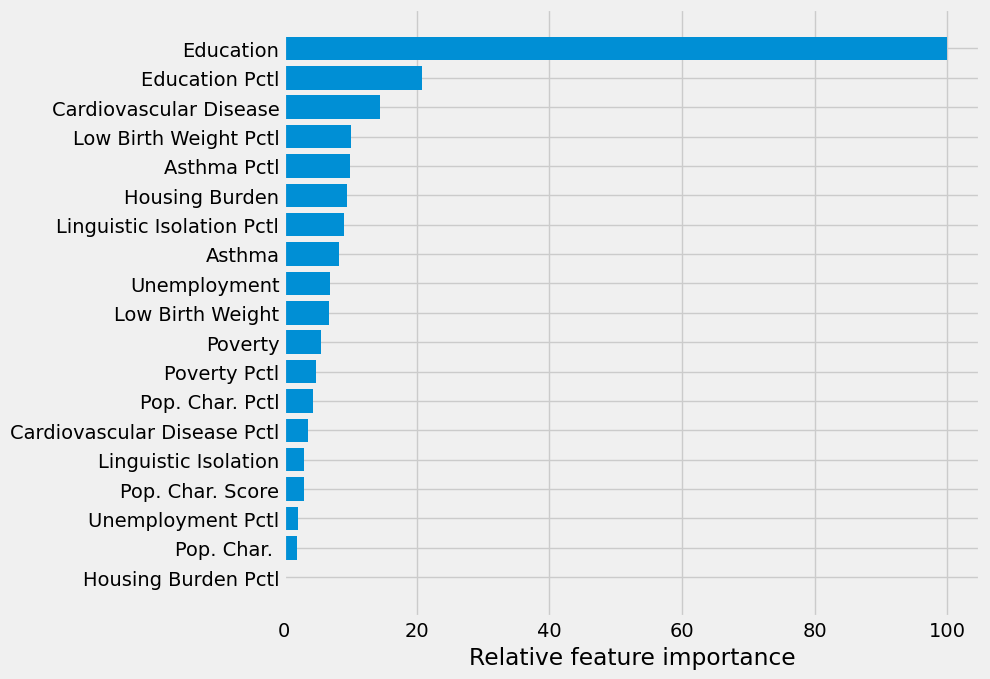

In [18]:
importance_plot(first_tree)

**Question 2.2 (2pts)** Which features have the highest relative importance scores? What can you conclude about the influence of these features on pollution exposure?

**ANSWER:** *YOUR ANSWER HERE*

*SOLUTION*

*The variables associated with Education have high importance scores. This does not give us ANY information about the influence of education on pollution exposure; instead it just tells us these things are correlated.*

----

## Section 3: Ensemble methods<a name = 'ensemble'></a>

In the previous section, we were focusing on fitting one tree. You may have noticed that, although the training scores were extremely high, the validation scores usually weren't as high. This is where ensemble methods (namely, bagging, random forests, and boosting) come in. We call them "ensemble methods" because we fit many trees and then aggregate the models to avoid overfitting. The benefits of using ensemble methods may not be immediately apparent with the training and validation data, but might become clearer when we evaluate all our models on the test data at the end of the assignment.

**Question 3.1a (3pts)** Distinguish among bagging, random forests, and boosting. What kind of ensemble methodology does each use?

**ANSWER:** *YOUR ANSWER HERE*

* Bagging:
* Random Forest:
* Boosting

*SOLUTION*
*Bagging bootstraps new datasets from the original data to fit many decision trees and then averages across all the decision trees. Random forests use the same approach as bagging, but only use a random subset of features when fitting individual trees. Boosting sequentially builds trees such that each tree is fit to lower the previous tree's residuals.* 


**Question 3.1b (1pt)** Name at least one advantage and one drawback of using an ensemble method compared to a single decision tree.

**ANSWER:** *YOUR ANSWER HERE*

*Solution: Ensemble methods often lead to better model performance, but they are more computationally intensive and less interpretable than decision trees.* 

----

Let's start with bagging!

Bagging takes in $B$ different bootstrapped training data sets and trains a tree on each training set to get $\hat{f}^{*b}(x)$. Then, it averages all of the predictions to get 

$$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B}\hat{f}^{*b}(x)$$

Let's proceed by using `BaggingClassifier` from scikit-learn's ensemble module ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)). 

**Question 3.2 (1pt)** Use the training data (`X_train` and `y_train`) to fit the bagging classifier. Call your model `bag_tree`. Score the model using the validation data.  Use `random_state=2021`, `n_estimators = 150`, and `max_features = 19`.

In [19]:
# import Bagging Classifer
from sklearn.ensemble import BaggingClassifier

In [ ]:
# YOUR CODE HERE
bag_tree = ...
bag_tree.fit(...)

bag_train_score = ...
bag_val_score = ...

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

In [20]:
# solution
bag_tree = BaggingClassifier(random_state = 2021, n_estimators = 150, max_features = 19)
bag_tree.fit(X_train, y_train)

bag_train_score = bag_tree.score(X_train, y_train)
bag_val_score = bag_tree.score(X_val, y_val)

print('Train Score: ', bag_train_score)
print('Validation Score: ', bag_val_score)

Train Score:  1.0
Validation Score:  0.815068493150685


When we fit our single `first_tree`, which contained a *lot* of nodes, we could have also tuned its hyperparameters. Some of these nodes had a gini score of 0 or have small sample numbers, possibly indicating overfitting. Adjusting the hyperparameters of the tree, such as `max_depth`, `max_features`, and `max_leaf_nodes`, could help us overcome some of these problems. 

----
Now, we'll move on to random forests.

Random forests take a similar approach to bagging, in which we fit various decision trees on resampled data. But, when each tree is constructed, not every feature is considered as a split candidate for each decision point; we only take a subset of the total predictors in the model.

The idea behind a random forest is that adding randomization into the features that create the model and then averaging predictions across models will produce a model that is not as overfit to the training data, and is in turn more reliable for prediction.

We'll use scikit-learn's `RandomForestClassifier()` to implement our model. The documentation can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Question 3.4 (1pt)** Create a RandomForestClassifier, fit the training data, and score the model. Call the model `rf_tree`. Score the model using the validation data.  Use `random_state=2021` and `n_estimators = 150`.

In [21]:
# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# YOUR CODE HERE
rf_tree = ...
rf_tree.fit(...)

rf_train_score = ...
rf_val_score = ...

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

In [22]:
# solution
rf_tree = RandomForestClassifier(n_estimators = 150, random_state=2021)
rf_tree.fit(X_train, y_train)

rf_train_score = rf_tree.score(X_train, y_train)
rf_val_score = rf_tree.score(X_val, y_val)

print('Train Score: ', rf_train_score)
print('Validation Score: ', rf_val_score)

Train Score:  1.0
Validation Score:  0.8184931506849316


Now we'd like to cross validate to identify the best hyperparameters for the RF.  Fortunately, we don't have to test various parameters by manually inputting them and running the cell, which would be exhausting! Instead, we can use [`RandomizedSearchCV` from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to help us find hyperparameters that lower our error. 

`RandomizedSeachCV` takes in a model, a distribution of parameters we want to test in the model, and other parameters that we can adjust. Of the latter, we'll only use `cv` and `n_iter` along with the two required arguments. 

The parameter distribution (`param_dist`) is a dictionary that takes in the parameter name as a key and a range of random values that we want to test. We'll be using `randint` from scipy.stats. Read through and then run the following cell -- we will also fit the CV search which will take some time.

(Note, we're giving you the code for the random forest, but you'll need to replicate this yourself for gradient boosting, up next.)

In [23]:
# run this cell
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'max_leaf_nodes': randint(3, 100),
              'min_samples_leaf': randint(1, 10),
              'min_samples_split': randint(2, 20)}

rf_tree_rnd_search = RandomizedSearchCV(RandomForestClassifier(n_estimators = 150, random_state=2021),
                                        param_distributions=param_dist, 
                                        cv=5, n_iter=5, random_state = 2021)

rf_tree_rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=150,
                                                    random_state=2021),
                   n_iter=5,
                   param_distributions={'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148122060>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1480de9f0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x148122090>},
                   random_state=2021)

In [24]:
print(rf_tree_rnd_search.best_score_) # This is cross validation error from the training data set.
print(rf_tree_rnd_search.best_params_)

0.8515844155844154
{'max_leaf_nodes': 88, 'min_samples_leaf': 1, 'min_samples_split': 15}


----
Lastly, we'll cover boosting, which is yet another approach to improve a decision tree model. The boosting approach grows a tree slowly. Each boosting algorithm has a slightly different approach, but the general idea is the same behind each one.

Scikit-learn has two boosting algorithms. We'll focus on `GradientBoostingClassifer`. For your awareness, the other algorithm is `AdaBoostClassifier` (for ADAptive BOOSTing). The adaptive part of the algorithm comes from how it updates the data for each weak model in the sequence; it combines many relatively weak and inaccurate classifiers. So it shines when a regular classifier doesn't perform well with a given dataset. However, it doesn't handle noisy data or outliers well. With our CES 4.0 response variable, our data is basically polarized -- we're taking values from the top and bottom 10% -- which means it might not work as well as we want it to. So, we'll use `GradientBoostingClassifier` instead. 

Gradient boosting involves three elements:
1. A loss function to be optimized.
2. A weak learner to make predictions.
3. An additive model in which we add weak learners to minimize the loss function.

We'll use scikit-learn's `GradientBoostingClassifier` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) to see how it performs with our data.

**Question 3.5 (1pt)** We'll do this for the last time! Fit the training data to the GradientBoostingClassifier and score the model. Use `random_state=2021` and `n_estimators = 150`.

In [25]:
# import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# YOUR CODE HERE 


gb_tree = ...
gb_tree.fit(...)

gb_train_score = ...
gb_val_score = ...

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

In [26]:
# solution
gb_tree = GradientBoostingClassifier(random_state=2021, n_estimators=150)
gb_tree.fit(X_train, y_train)

gb_train_score = gb_tree.score(X_train, y_train)
gb_val_score = gb_tree.score(X_val, y_val)

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

Train Score:  0.976027397260274
Validation Score:  0.8082191780821918


**Question 3.6 (1pt)** In the case of boosting, cross validation helps with hyperparameter tuning.  Pick *two* parameters you'd like to search over, choose a range for them, and pass them into `RandomizedSearchCV` as we did earlier in part 3.  Then save and print out the best parameters. (***NOTE: This will probably take a while--possibly several minutes!--to run.***)

In [ ]:
param_dist = {...} # specify a dictionary with two parameters and the range of calues over which you'd like to choose values

rnd_gb_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=2021, n_estimators=150), 
                                   param_distributions=param_dist, 
                                   cv=5, n_iter=10)

rnd_gb_search.fit(X_train, y_train)

print(rnd_gb_search.best_params_)

In [27]:
#POSSIBLE SOLUTION

param_dist = {'learning_rate': randint(1, 10),
              'max_features': randint(2, 19)}

rnd_gb_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=2021, n_estimators=150), 
                                   param_distributions=param_dist, 
                                   cv=5, n_iter=5)

rnd_gb_search.fit(X_train, y_train)

print(rnd_gb_search.best_params_)

{'learning_rate': 1, 'max_features': 17}


**Question 3.7 (1pt)** Once the search is complete, set the parameters and re-fit and score the model.

In [ ]:
# YOUR CODE HERE
gb_train_score = ...
gb_val_score = ...

print('Train Score: ', gb_train_score)
print('Validation Score: ', gb_val_score)

In [28]:
# Possible SOLUTION
gb_tree.set_params(learning_rate=1, max_features = 17, random_state=2021)
gb_tree.fit(X_train, y_train) 

print('Train Score: ', gb_tree.score(X_train, y_train))
print('Validation Score: ', gb_tree.score(X_val, y_val))

Train Score:  1.0
Validation Score:  0.8116438356164384


**Question 3.8 (1pt)** Use `importance_plot` to visualize the relative importance of the features in `gb_tree`. How do the results compare to the `first_tree` feature importance?

In [ ]:
# YOUR CODE HERE
importance_plot(...)

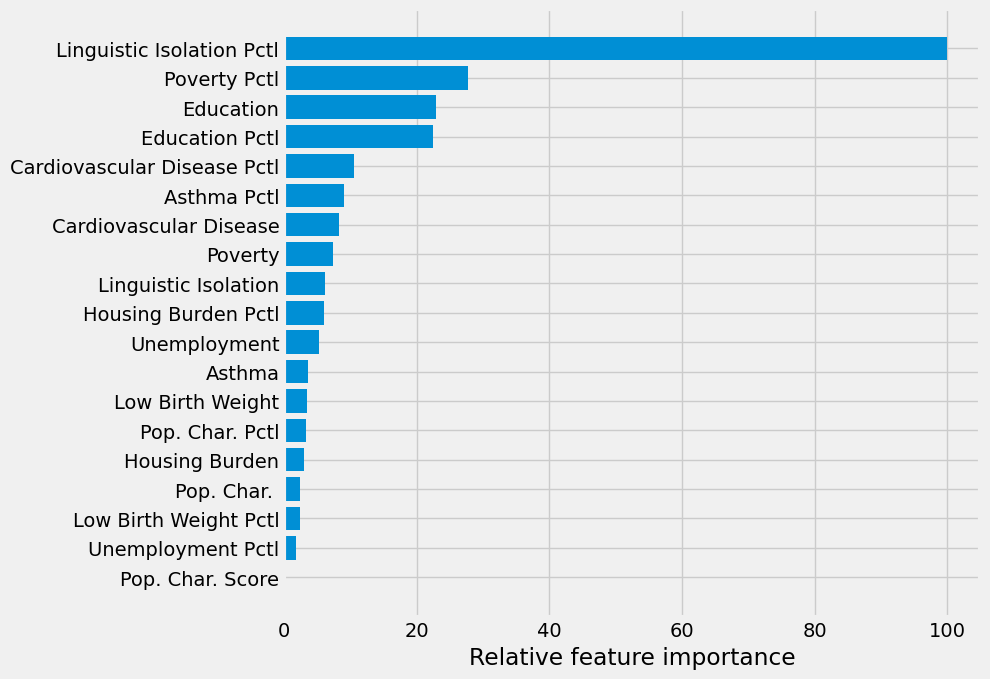

In [29]:
# SOLUTION
importance_plot(gb_tree)

**ANSWER:** *YOUR ANSWER HERE*

----

We've gone through many methods of creating a decision tree and tuning and improving it, as well as various algorithms that use multiple trees to create a more reliable prediction. Even though we've primarily have been testing our models with the training and validation set, we would still need to test each of these models to see which one is the optimal one to choose given our data and how the model performs.

**Question 3.9 (1pt)** run the following cell. Which model scores the highest on the test data? Which scores the lowest?

In [30]:
models = [first_tree, bag_tree, rf_tree, rf_tree_rnd_search, gb_tree]
for i in models:
    print('Test Score: ', i.score(X_test, y_test))

Test Score:  0.757679180887372
Test Score:  0.8361774744027304
Test Score:  0.8225255972696246
Test Score:  0.8327645051194539
Test Score:  0.8156996587030717


**ANSWER:** *YOUR ANSWER HERE*

*SOLUTION* Answers might vary depending on the parameters students chose for the GB problem. In this case, the top-performing model was the bagged tree, and the worst-performing model was the single tree.

**Question 3.10 (1pt)** Select your best-performing model according to Question 3.9 and examine its performance using a confusion matrix. How is the precision/recall of your model? (Remember that precision is the fraction of positives that are actually positive and recall is the fraction of actual positives that get identified.) 
    


In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
# YOUR CODE HERE

In [33]:
# POTENTIAL SOLUTION
y_hat = bag_tree.predict(X_test)
print(confusion_matrix(y_test,y_hat))  

[[120  23]
 [ 25 125]]


**ANSWER:** *YOUR ANSWER HERE*

*SOLUTION: Answers will vary depending on model*

----

## Submission

Congrats, you're done with Homework 9! 

In order to turn in this assignment, go to the toolbar and click **File** -> **Download as** -> **HTML** and submit through bCourses.

----

Notebook developed by: Jason Jiang and Duncan Callaway

Data Science Modules: http://data.berkeley.edu/education/modules